In [1]:
library(corrplot)
library(Amelia)
library(caret)

corrplot 0.84 loaded

Loading required package: Rcpp

## 
## Amelia II: Multiple Imputation
## (Version 1.7.6, built: 2019-11-24)
## Copyright (C) 2005-2021 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 

Loading required package: lattice

Loading required package: ggplot2



In [2]:
data = read.csv('../../Data/binary.csv')

In [3]:
head(data)

,admit,gre,gpa,rank
,<int>,<int>,<dbl>,<int>
1,0,380,3.61,3
2,1,660,3.67,3
3,1,800,4.00,1
4,1,640,3.19,4
5,0,520,2.93,4
6,1,760,3.00,2


In [4]:
tail(data)

,admit,gre,gpa,rank
,<int>,<int>,<dbl>,<int>
395,1,460,3.99,3
396,0,620,4.00,2
397,0,560,3.04,3
398,0,460,2.63,2
399,0,700,3.65,2
400,0,600,3.89,3


In [5]:
summary(data)

     admit             gre             gpa             rank      
 Min.   :0.0000   Min.   :220.0   Min.   :2.260   Min.   :1.000  
 1st Qu.:0.0000   1st Qu.:520.0   1st Qu.:3.130   1st Qu.:2.000  
 Median :0.0000   Median :580.0   Median :3.395   Median :2.000  
 Mean   :0.3175   Mean   :587.7   Mean   :3.390   Mean   :2.485  
 3rd Qu.:1.0000   3rd Qu.:660.0   3rd Qu.:3.670   3rd Qu.:3.000  
 Max.   :1.0000   Max.   :800.0   Max.   :4.000   Max.   :4.000  

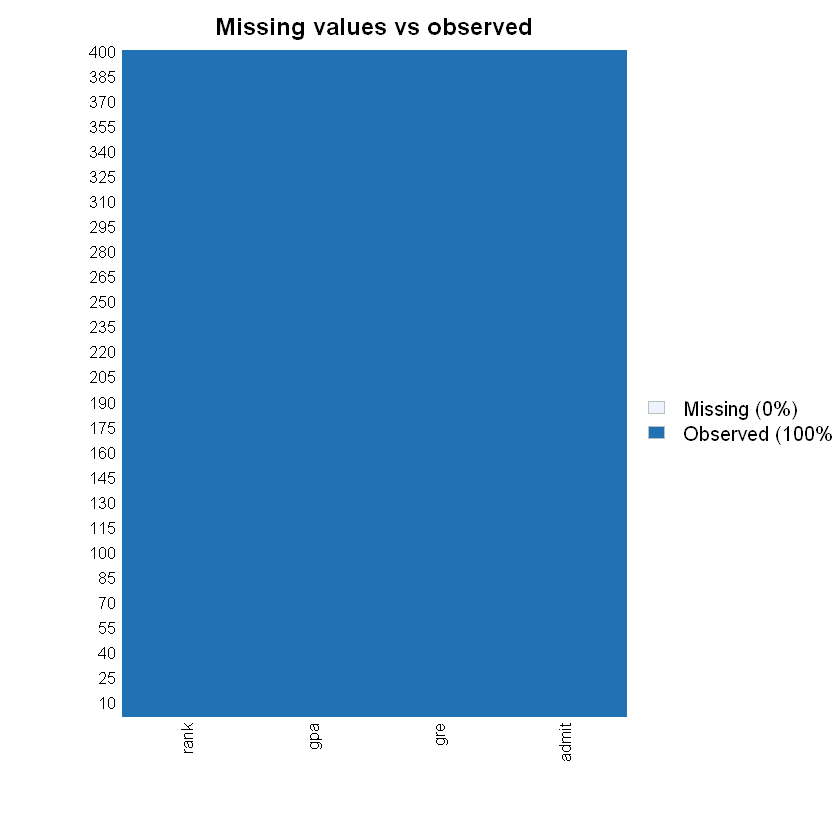

In [6]:
# Check missing value
missmap(data, main = "Missing values vs observed")

In [7]:
# Count element in each Class
print(table(data$admit))


  0   1 
273 127 


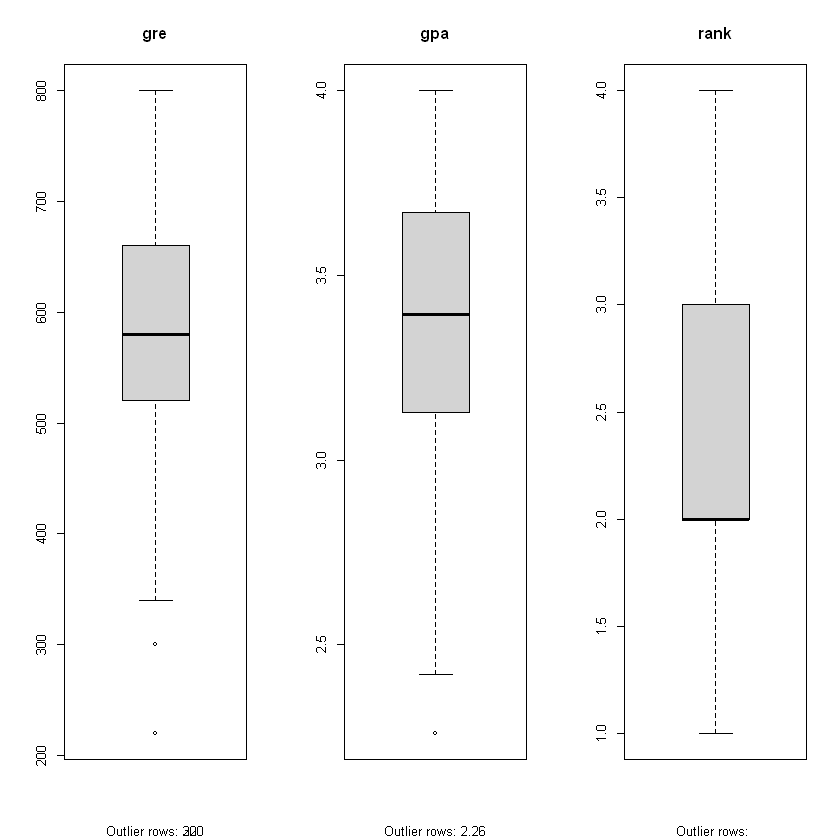

In [8]:
par(mfrow = c(1, 3))
boxplot(data$gre, main = "gre", 
        sub = paste("Outlier rows:", boxplot.stats(data$gre)$out))
boxplot(data$gpa, main = "gpa", 
        sub = paste("Outlier rows:", boxplot.stats(data$gpa)$out))
boxplot(data$rank, main = "rank", 
        sub = paste("Outlier rows:", boxplot.stats(data$rank)$out))

In [9]:
gre_outliers = boxplot.stats(data$gre)$out
print("gre_outliers:")
print(gre_outliers)
print(paste("Numrows:", sum(data$gre == gre_outliers[1])))

[1] "gre_outliers:"
[1] 300 300 220 300
[1] "Numrows: 3"


In [10]:
gpa_outliers = boxplot.stats(data$gpa)$out
print("gpa_outliers:")
print(gpa_outliers)
print(paste("Numrows:", sum(data$gpa == gpa_outliers[1])))

[1] "gpa_outliers:"
[1] 2.26
[1] "Numrows: 1"


In [11]:
rank_outliers = boxplot.stats(data$rank)$out
print("rank_outliers:")
print(rank_outliers)
print(paste("Numrows:", sum(data$rank == rank_outliers[1])))

[1] "rank_outliers:"
integer(0)
[1] "Numrows: NA"


In [12]:
print(paste("Before drop:", nrow(data)))
data = data[data$gre != gre_outliers[1],]
data = data[data$gpa != gpa_outliers[1],]
print(paste("After drop", nrow(data)))

[1] "Before drop: 400"
[1] "After drop 396"


            gre         gpa        rank
gre   1.0000000  0.36594595 -0.11094266
gpa   0.3659460  1.00000000 -0.04193439
rank -0.1109427 -0.04193439  1.00000000


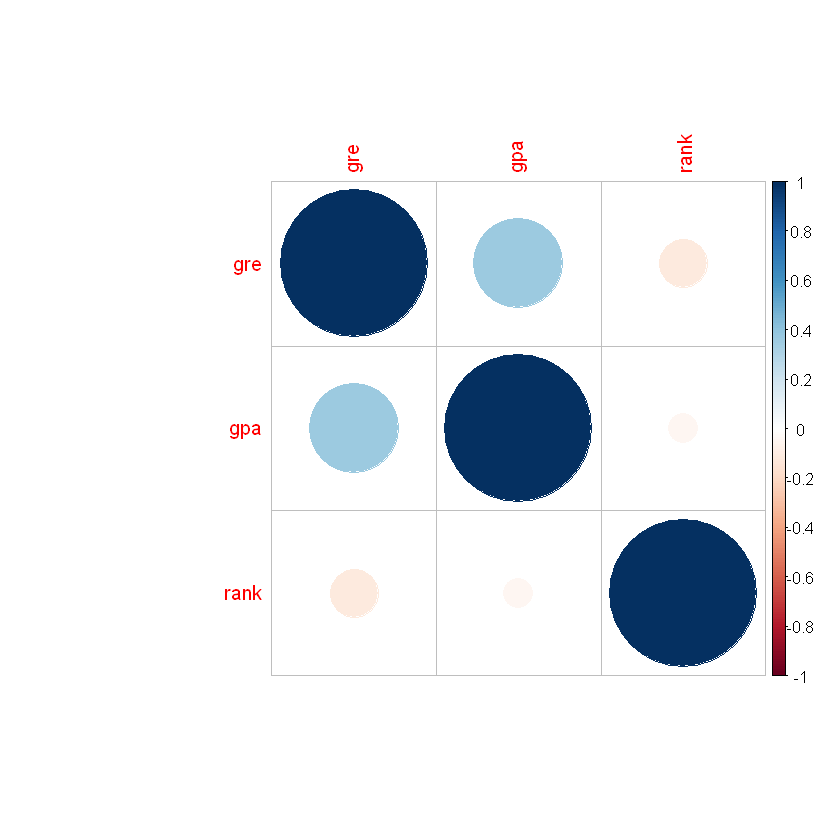

In [13]:
# Calculate the correlation between each pair of numeric variables
correlations = cor(data[, 2:4])
print(correlations)
corrplot(correlations, method = "circle")

In [14]:
# Create training and test data samples from orginal data
set.seed(42) # Setting seed to reproduce results of ramdom sampling
trainingRowIndex = sample(1: nrow(data), 0.7 * nrow(data))
trainingData = data[trainingRowIndex, ]
testData = data[- trainingRowIndex,]

print(nrow(trainingData))
print(nrow(testData))

[1] 277
[1] 119


In [15]:
# estimate a logistic regression model using the glm (generalized linear model) function
mylogit = glm(admit ~ gre+gpa+rank, data = trainingData, family = "binomial")

In [16]:
# Review dianostic measures
print(summary(mylogit))


Call:
glm(formula = admit ~ gre + gpa + rank, family = "binomial", 
    data = trainingData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6304  -0.9182  -0.6513   1.1352   2.1282  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.739932   1.326928  -2.818 0.004825 ** 
gre          0.001974   0.001315   1.501 0.133443    
gpa          0.943463   0.387480   2.435 0.014897 *  
rank        -0.562940   0.150997  -3.728 0.000193 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 353.55  on 276  degrees of freedom
Residual deviance: 325.04  on 273  degrees of freedom
AIC: 333.04

Number of Fisher Scoring iterations: 3



In [17]:
pred = predict(mylogit, newdata = testData, type = "response")
pred_value = ifelse(pred > 0.5, 1, 0)
print("Test data adimit vs predict (10 rows):")
result = data.frame(testAdmit = testData$admit[30:40], pred_value[30:40])
print(result)

[1] "Test data adimit vs predict (10 rows):"
    testAdmit pred_value.30.40.
97          0                 0
100         0                 0
102         0                 0
105         1                 1
118         0                 1
120         0                 0
124         0                 0
126         0                 0
130         0                 0
132         0                 0
133         0                 0


In [18]:
# Solution 1
accuracy = table(pred_value, testData[, "admit"])
accuracy = sum(diag(accuracy)) / sum(accuracy)
print(paste("Accuracy s1:", accuracy))
# Solution 2
misClasificError = mean(pred_value != testData$admit)
print(paste("Accuracy s2:", 1 - misClasificError))

[1] "Accuracy s1: 0.672268907563025"
[1] "Accuracy s2: 0.672268907563025"


In [19]:
confusionMatrix(as.factor(pred_value), as.factor(testData$admit))

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 72 25
         1 14  8
                                          
               Accuracy : 0.6723          
                 95% CI : (0.5802, 0.7555)
    No Information Rate : 0.7227          
    P-Value [Acc > NIR] : 0.9067          
                                          
                  Kappa : 0.0887          
                                          
 Mcnemar's Test P-Value : 0.1093          
                                          
            Sensitivity : 0.8372          
            Specificity : 0.2424          
         Pos Pred Value : 0.7423          
         Neg Pred Value : 0.3636          
             Prevalence : 0.7227          
         Detection Rate : 0.6050          
   Detection Prevalence : 0.8151          
      Balanced Accuracy : 0.5398          
                                          
       'Positive' Class : 0               
                                    